##  a project about chest cancer detection using machine learning and deep leaning (CNN):

* Adenocarcinoma

Adenocarcinoma of the lung: Lung adenocarcinoma is the most common form of lung cancer
accounting for 30 percent of all cases overall and about 40 percent
of all non-small cell lung cancer occurrences. Adenocarcinomas are
found in several common cancers, including breast, prostate and colorectal.
Adenocarcinomas of the lung are found in the outer region of the lung
in glands that secrete mucus and help us breathe.
Symptoms include coughing, hoarseness, weight loss and weakness.

* Large cell carcinoma

Large-cell undifferentiated carcinoma: Large-cell undifferentiated carcinoma lung cancer grows and spreads quickly and can
be found anywhere in the lung. This type of lung cancer usually accounts for 10
to 15 percent of all cases of NSCLC.
Large-cell undifferentiated carcinoma tends to grow and spread quickly.

* Squamous cell carcinoma

Squamous cell: This type of lung cancer is found centrally in the lung,
where the larger bronchi join the trachea to the lung,
or in one of the main airway branches.
Squamous cell lung cancer is responsible for about 30 percent of all non-small
cell lung cancers, and is generally linked to smoking.

And the last folder is the normal CT-Scan images. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import layers
import cv2
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from matplotlib.pyplot import imread
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
data_folder= r'D:\Programming\ML\Datasets\Chest CT-Scan\Data'


train_dir = data_folder + '\\train'
val_dir   = data_folder + '\\val'
test_dir  = data_folder + '\\test'


print(train_dir)
print(val_dir)
print(test_dir)


D:\Programming\ML\Datasets\Chest CT-Scan\Data\train
D:\Programming\ML\Datasets\Chest CT-Scan\Data\val
D:\Programming\ML\Datasets\Chest CT-Scan\Data\test


In [5]:
os.listdir(train_dir)

['adenocarcinoma_left.lower.lobe',
 'large.cell.carcinoma_left.hilum',
 'normal',
 'squamous.cell.carcinoma_left.hilum']

In [9]:
train_images = []
train_labels = [] 

for sub_folder in os.listdir(train_dir):
    sub_path= train_dir +"\\"+ sub_folder
    label= sub_path.split("\\")[-1]

    for img_path in tqdm(os.listdir(sub_path)):
        
        img = sub_path +'\\'+ img_path
        img = cv2.imread(img)       
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float16')
        img = np.array(img)/255.
        train_images.append(img)
        train_labels.append(label)

100%|██████████| 155/155 [00:02<00:00, 69.52it/s]


In [10]:
train_images = np.array(train_images)

train_labels = np.array(train_labels)


In [12]:
len(train_images) , len(train_labels)

(613, 613)

### Viewing some random images 

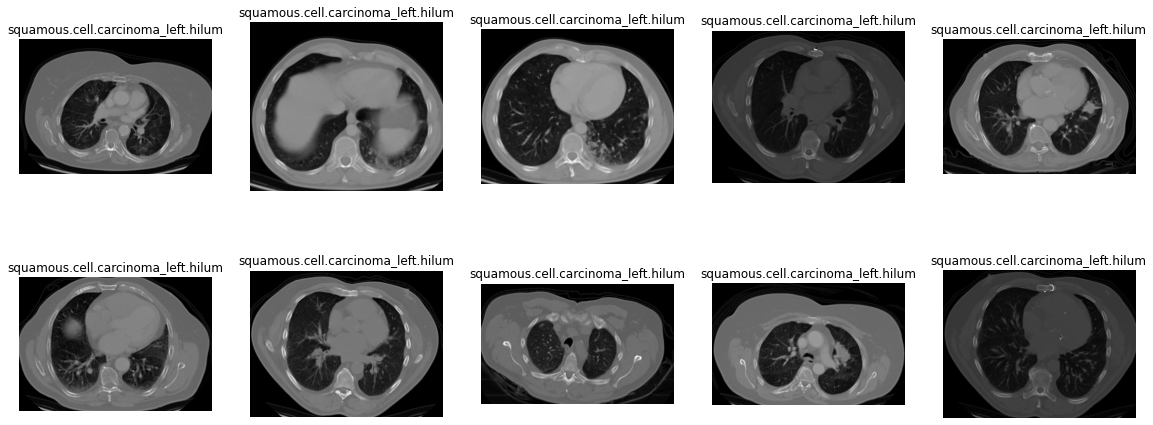

In [17]:
train_folder  = r'D:\Programming\ML\Datasets\Chest CT-Scan\Data\train'

plt.figure(figsize=(20 , 8))
for i in range (5):
    
    subfolder = random.choice(os.listdir(train_folder))
    
    cancer_name = os.path.join(train_folder , subfolder)
    
    for i in range (10):
    
        file = random.choice(os.listdir(cancer_name))
        
        image_path = os.path.join(cancer_name , file)

        img = imread(image_path)

        ax = plt.subplot(2 , 5 , i+1)
        
        ax.title.set_text(sub_folder)
        plt.axis('off')

        plt.imshow(img)

In [18]:
test_images = []
test_labels = [] 

for sub_folder in os.listdir(test_dir):
    sub_path= test_dir +"\\"+ sub_folder
    label= sub_path.split("\\")[-1]

    for img_path in tqdm(os.listdir(sub_path)):
        
        img = sub_path +'\\'+ img_path
        img = cv2.imread(img)       
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float16')
        img = np.array(img)/255.
        test_images.append(img)
        test_labels.append(label)

100%|██████████| 90/90 [00:01<00:00, 61.64it/s]


In [19]:
len(test_images) , len(test_labels)

(315, 315)

In [20]:
type(test_images)

list

In [22]:
test_images = np.array(test_images)

train_labels= np.array(train_labels)

In [23]:
type(test_images)

numpy.ndarray

In [24]:
#Encode labels from text to integers.

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [25]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [26]:
## Transfer learning using VGG16 pretrained model.


VGG_model = tf.keras.applications.VGG16(weights='imagenet', 
                                        include_top=False, 
                                        input_shape=(224, 224, 3))


for layer in VGG_model.layers:
    layer.trainable = False
    

In [27]:
# use features from convolutional network for XGBOOST
#with tf.device('/device:CPU:0'):
feature_extractor= VGG_model.predict(x_train)

20/20 [==============================] - 21s 331ms/step


In [37]:
feature_extractor.shape

(613, 7, 7, 512)

In [38]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features  # X is the input to XGBOOST

In [53]:
xgboost = XGBClassifier()

param_grid = {'n_estimators': [100, 150, 200],
              'max_depth':  [0, 1 , 2 , 3]}


xgboost_gs = GridSearchCV(estimator=xgboost,
                          param_grid=param_grid,
                          cv=3,
                          verbose=1)


xgboost_gs.fit(X_for_training, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\moham\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\moham\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moham\anaconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\moham\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1490, in fit
    self._Booster = train(
  File "C:\Users\moham\anaconda3\lib\site-packages\xgboost\core.py", line 620, 

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max

In [54]:
xgboost_gs.best_params_

{'max_depth': 1, 'n_estimators': 150}

In [55]:
X_test_feature = VGG_model.predict(x_test)


10/10 [==============================] - 6s 655ms/step


In [57]:
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [58]:
#Now predict using the trained XGBOOST model. 
prediction_xgboost = xgboost_gs.predict(X_test_features)

#Inverse le transform to get original label back. 
prediction_xgboost = le.inverse_transform(prediction_xgboost)

In [61]:
from sklearn.metrics import accuracy_score

print(f"Accuracy =  {accuracy_score(test_labels, prediction_xgboost)*100:.2f}%")

Accuracy =  75.24%


<AxesSubplot:>

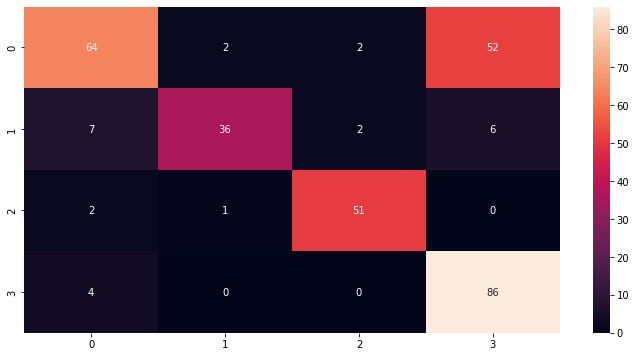

In [63]:
# Plotting confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(12,6))
cm = confusion_matrix(test_labels, prediction_xgboost)

sns.heatmap(cm, annot=True)

### Prediction for 10 images:

In [67]:
for i in range(10):
    n=np.random.randint(0, x_test.shape[0])
    img = x_test[n]
    #plt.imshow(img)
    input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
    input_img_feature=VGG_model.predict(input_img)
    input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
    prediction_xgboost = xgboost_gs.predict(input_img_features)[0] 
    prediction_xgboost = le.inverse_transform([prediction_xgboost])  #Reverse the label encoder to original name
    print("The prediction for this image is: ", prediction_xgboost)
    print("The actual label for this image is: ", test_labels[n])   
    print()

1/1 [==============================] - 0s 25ms/step
The prediction for this image is:  ['squamous.cell.carcinoma_left.hilum']
The actual label for this image is:  large.cell.carcinoma_left.hilum

1/1 [==============================] - 0s 26ms/step
The prediction for this image is:  ['squamous.cell.carcinoma_left.hilum']
The actual label for this image is:  squamous.cell.carcinoma_left.hilum

1/1 [==============================] - 0s 36ms/step
The prediction for this image is:  ['squamous.cell.carcinoma_left.hilum']
The actual label for this image is:  squamous.cell.carcinoma_left.hilum

1/1 [==============================] - 0s 36ms/step
The prediction for this image is:  ['squamous.cell.carcinoma_left.hilum']
The actual label for this image is:  adenocarcinoma_left.lower.lobe

1/1 [==============================] - 0s 35ms/step
The prediction for this image is:  ['normal']
The actual label for this image is:  normal

1/1 [==============================] - 0s 36ms/step
The prediction f